# *HW1 -- Mahan Mirza Khanlari -- Computational*

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'

# **Question 1**

Here we try to integrate the function:
$$
f(x)=\frac{1}{x^{3/2}}
$$ 
over the interval 
$
[1,5]
$ 
using three different methods:

1. **Rectangle Rule**
2. **Trapezoidal Rule**
3. **Simpson's Rule**

The exact analytic integral is given by
$$
I_{\text{exact}} = 2\left(1-\frac{1}{\sqrt{5}}\right).
$$

We also compare the numerical results to the result from `scipy.integrate.quad`.

---

## Key Points

### Reusing Function Evaluations

The trapezoidal rule,
$$
I = \Delta x \sum_{i=1}^{N} \frac{f(x_i) + f(x_{i+1})}{2},
$$
appears to require two function evaluations per subinterval. But the right endpoint of one subinterval is the left endpoint of the next. So we avoid double evaluations by making all grid points **once** using:
$$
x = \texttt{np.linspace(a, b, N+1)},
$$
Then:
- In the **Trapezoidal Rule**, we weight the endpoints with $0.5$ and the interior points with $1$, because each unique $f(x)$ should be computed only once.
- In **Simpson's Rule**, we use the same idea to make the grid points, then apply Simpson's weights by slicing:
  - $$ \texttt{x[1:-1:2]} $$ selects odd-indexed interior points (multiplied by $4$),
  - $$ \texttt{x[2:-1:2]} $$ selects even-indexed interior points (multiplied by $2$).

### Notation Differences

In the problem, the endpoints are $f(a)$ and $f(b)$, and the sums over interior points are $a + (2i-1)\Delta x$ and $a + 2i\Delta x$. In the code:
- We represent the endpoints as `x[0]`and `x[-1]`.
- The slicing `x[1:-1:2]` and `x[2:-1:2]` corresponds to the sums over the odd-indexed and even-indexed interior points.
- 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import quad

# Integration limits & Step size
a, b = 1, 5

In [29]:
#integrand
def f(x):
    return x**(-1.5)

# Analytic solution
def exact_integral():
    return 2 * (1 - 1/np.sqrt(5))

# Compute analytic result and high-accuracy quad result for comparison
I_exact = exact_integral()
I_quad, error_quad = quad(f, a, b)

In [30]:
# Rectangle Rule
def rectangle_rule(N):
    dx = (b - a) / N 
    x = a + np.arange(N) * dx 
    return dx * np.sum(f(x))  

# Trapezoidal Rule
def trapezoidal_rule(N):
    dx = (b - a) / N 
    x = np.linspace(a, b, N+1) 
    return dx * (0.5 * f(x[0]) + np.sum(f(x[1:-1])) + 0.5 * f(x[-1]))

# Simpson's Rule
def simpsons_rule(N):             
    dx = (b - a) / N 
    x = np.linspace(a, b, N+1)      
    S = f(x[0]) + f(x[-1])           
    S += 4 * np.sum(f(x[1:-1:2])) 
    S += 2 * np.sum(f(x[2:-1:2]))   
    return dx/3 * S

In [31]:
# Generate a range of N values to test the convergence and timing
N_values = np.linspace(5, 1000, 100, dtype=int)
errors_rect, errors_trap, errors_simp = [], [], []
times_rect, times_trap, times_simp = [], [], []

# Loop over the different N values
for N in N_values:
    start = time.time()
    I_rect = rectangle_rule(N)
    times_rect.append(time.time() - start)
    errors_rect.append(abs(I_rect - I_exact) / I_exact)
    
    start = time.time()
    I_trap = trapezoidal_rule(N)
    times_trap.append(time.time() - start)
    errors_trap.append(abs(I_trap - I_exact) / I_exact)
    
    # Adjust N for Simpson's rule to be even
    N_simpson = N if N % 2 == 0 else N + 1
    start = time.time()
    I_simp = simpsons_rule(N_simpson)
    times_simp.append(time.time() - start)
    errors_simp.append(abs(I_simp - I_exact) / I_exact)

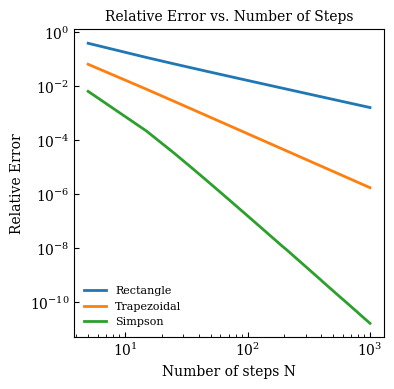

In [69]:
plt.figure(figsize=(4, 4))
plt.loglog(N_values, errors_rect, label='Rectangle')
plt.loglog(N_values, errors_trap, label='Trapezoidal')
plt.loglog(N_values, errors_simp, label="Simpson")
plt.xlabel('Number of steps N')
plt.ylabel('Relative Error')
plt.title('Relative Error vs. Number of Steps',fontsize=10)
plt.legend(frameon=False,fontsize=8,loc='lower left')
plt.show()

In [33]:
print("Exact integral:", I_exact)
print("scipy.integrate.quad: {:.8f} with error estimate {:.2e}".format(I_quad, error_quad))
print("\nTotal computation time (seconds):")
print("Rectangle Rule: {:.6f}".format(np.sum(times_rect)))
print("Trapezoidal Rule: {:.6f}".format(np.sum(times_trap)))
print("Simpson's Rule: {:.6f}".format(np.sum(times_simp)))

Exact integral: 1.1055728090000843
scipy.integrate.quad: 1.10557281 with error estimate 5.44e-13

Total computation time (seconds):
Rectangle Rule: 0.006229
Trapezoidal Rule: 0.009126
Simpson's Rule: 0.008154


**Summary & Results:**
  - **Rectangle Rule:** Use left endpoints. **The least Accurate of the 3**
    
  - **Trapezoidal Rule:** Make a grid and apply weights (0.5 for the endpoints, 1 for interior points) to avoid double function evaluations. **Better than Rectangle but slightly slower**

    
  - **Simpson's Rule:** Again make the grid, and then uses slicing to apply Simpson's weights (4 for odd-indexed interior points and 2 for even-indexed ones). **By far the most accurate for the same value of N**


# **Question 2**

Here we try to simulate particles following the Hernquist (1990) density profile.
- **Density Profile:**

  $$\rho(r) = \frac{M}{2\pi}\frac{a}{r(r+a)^3},$$

  where $M$ is the total mass and $a$ is the scale radius.

- **Cumulative Mass Distribution:**

  $$\frac{M(r)}{M} = \left(\frac{r}{r+a}\right)^2.$$

  We invert this and obtain the sampling for the radius:

  $$r = a\,\frac{\sqrt{u}}{1-\sqrt{u}}, \quad u \sim (0,1).$$

## Energy and Velocity Sampling

### Distribution Function $f(E)$

We use Eq 17 of the paper for f(E) with the relative energy defined as $\epsilon = -E$ and

$$
q = \sqrt{\frac{\epsilon\,a}{GM}}.
$$

This function is valid only for bound particles ($q < 1$ and $E < 0$).

### Sampling Energy at a Given Radius

At a fixed radius $r$, the gravitational potential is:

$$\Phi(r) = -\frac{GM}{r+a},$$

and the allowed energies lie between $\Phi(r)$ and 0. The probability of energy at that particular radius is:

$$p(E|r) \propto f(E)\sqrt{E-\Phi(r)}.$$

We use acceptance-rejection method to sample energies from this distribution. In our code, the function `sample_energy_at_r(r)` implements this.

### Acceptance–Rejection Sampling Explanation 

**Key Points:**
- We are not using a cumulative energy distribution.  
- We are directly sampling from the differential probability density $p(E|r)$.

#### How it works

1. **Define the Target Function:**

   We set
   $$
   g(E) = f(E)\sqrt{E-\Phi(r)},
   $$
   which is proportional to the differential probability density $p(E|r)$.

2. **Determine the Allowed Energy Range:**

   For a particle at radius $r$, the energy must lie in the interval
   $$
   E \in [\Phi(r),\, 0].
   $$

3. **Estimate the Maximum Value:**

   We choose a grid of $E$ values between $\Phi(r)$ and 0 and compute $g(E)$ at these points. The maximum value of these computations, $g_{\text{max}}$, serves as our bounding function for that radius. *(In the code we choose ngrid=200 for the grid because after some tial test it seems to be an okay balance between computational cost and not underestimating $g_{\text{max}}$)*

4. **Generate a Candidate Sample:**

   - Randomly select a candidate energy $E^*$ uniformly from the interval $[\Phi(r), 0]$.
   - Randomly generate a number $y$ uniformly between 0 and $g_{\text{max}}$.

5. **Acceptance Test:**

   If 
   $$
   y < g(E^*),
   $$
   then accept $E^*$ as a valid sample; otherwise, reject it and generate $E^*$ again.

#### Sanity Check: Uniform $f(E)$

To verify this routine, we implement a sanity check where we set $f(E) = 1$. In that case, the probability becomes:

$$p(E|r) \propto \sqrt{E-\Phi(r)}.$$

We sample energies at a fixed radius (e.g., $r=10$ kpc, you can also change this and see it works for any r) and compare the histogram with the theoretical $\sqrt{E-\Phi}$ curve.

## Sampling Velocities

Once an energy $E$ is sampled, the speed is calculated by:

$$v = \sqrt{2(E-\Phi(r))}.$$

We then assign an isotropic direction to the velocity vector by randomly sampling angles.

## Radial Velocity Dispersion

After generating positions and velocities, we compute the radial velocity for each particle:

$$v_r = \frac{\mathbf{r} \cdot \mathbf{v}}{r}.$$

Particles are binned in logarithmically radial bins (the smaller the bins, the more accurate we get with the theory line), and the radial velocity dispersion is computed as:

$$\sigma_r^2(r) = \langle v_r^2 \rangle.$$

We compare the result with the theoretical prediction (Eq 10 of Hernquist, but we get a sqrt root of it):

## Plots

1. **Energy Distribution Sanity Check (Uniform $f(E)$):**
   - **Data:** Histogram of energies sampled at a fixed radius using $f(E)=1$.
   - **Theory:** Expected to follow $\propto \sqrt{E-\Phi(r)}$ (normalized).

2. **Radial Velocity Dispersion:**
   - **Data:** Simulation result computed from the binned radial velocity components.
   - **Theory:** The analytic prediction from Hernquist (Eq. 10).

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# Setup Parameters and Constants
np.random.seed(42)
M = 1e12  
a = 35.0      
G = 4.30091e-6 
N = int(1e6) #I suggest changing this to 1e4 or 1e5 for testing the code

In [44]:
# Hernquist Distribution Function f(E)
def f_E(E):
    epsilon = -E  
    q = np.sqrt(epsilon * a / (G * M))
    if q >= 1.0:
        return 0.0
    prefactor = M / (8 * np.sqrt(2) * np.pi**3 * a**3 * (G * M / a)**1.5)
    term1 = 3.0 * np.arcsin(q)
    term2 = q * np.sqrt(1.0 - q**2) * (1.0 - 2.0*q**2) * (8.0*q**4 - 8.0*q**2 - 3.0)
    return prefactor * (term1 + term2) / (1.0 - q**2)**(2.5)

#Sampling for Energy at a given r
def sample_energy_at_r(r, ngrid=200):
    Phi = -G * M / (r + a)
    E_min = Phi
    E_max = 0.0
    
    # Build a grid to estimate the maximum of g(E) = f(E)*sqrt(E-Phi)
    E_grid = np.linspace(E_min, E_max, ngrid)
    g_vals = np.array([f_E(E_val) * np.sqrt(E_val - Phi) for E_val in E_grid])
    g_max = g_vals.max()
    
    while True:
        E_candidate = np.random.uniform(E_min, E_max)
        g_candidate = f_E(E_candidate) * np.sqrt(E_candidate - Phi)
        if np.random.uniform(0, g_max) < g_candidate:
            return E_candidate

# Rejection Sampling for Energy (Uniform f(E)) Sanity Check
def sample_energy_uniform(r, ngrid=200):
    Phi = -G * M / (r + a)
    E_min = Phi
    E_max = 0.0
    
    E_grid = np.linspace(E_min, E_max, ngrid)
    g_vals = np.sqrt(E_grid - Phi)  # since f(E)=1
    g_max = g_vals.max()
    
    while True:
        E_candidate = np.random.uniform(E_min, E_max)
        g_candidate = np.sqrt(E_candidate - Phi)
        if np.random.uniform(0, g_max) < g_candidate:
            return E_candidate

# Sampling Velocity at a given r
def sample_velocity_at_r(r):
    Phi = -G * M / (r + a)
    E = sample_energy_at_r(r)
    v_mag = np.sqrt(2.0 * (E - Phi))

#giving a random direction to 
    costheta = np.random.uniform(-1.0, 1.0)
    sintheta = np.sqrt(1.0 - costheta**2)
    phi = np.random.uniform(0.0, 2*np.pi)
    vx = v_mag * sintheta * np.cos(phi)
    vy = v_mag * sintheta * np.sin(phi)
    vz = v_mag * costheta
    
    return np.array([vx, vy, vz]), E

# Inverse of M(r)/M for Sampling the radius
def sample_radius():
    u = np.random.uniform(0.0, 1.0)
    sqrt_u = np.sqrt(u)
    return a * sqrt_u / (1.0 - sqrt_u)

#giving a random direction
def sample_position():
    r = sample_radius()
    costheta = np.random.uniform(-1.0, 1.0)
    theta = np.arccos(costheta)
    phi = np.random.uniform(0.0, 2*np.pi)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * costheta
    return np.array([x, y, z]), r



# Theoretical Radial Velocity Dispersion (Hernquist Eq. 10)
def sigma_r_theoretical(r):
    r = np.asarray(r)
    r_a = r / a
    log_term = np.log((r + a) / r)
    poly = 25 + 52 * r_a + 42 * r_a**2 + 12 * r_a**3
    numerator = 12 * r * (r + a)**3 * log_term
    denominator = a**4
    term1 = numerator / denominator
    term2 = (r / (r + a)) * poly
    value = (G * M / (12 * a)) * (term1 - term2)
    # Return sqrt(value) if positive; else nan (elementwise)
    sigma = np.where(value > 0, np.sqrt(value), np.nan)
    return sigma

In [10]:
# Main Simulation: Generate Particle Positions
positions = np.empty((N, 3))
radii = np.empty(N)
for i in range(N):
    pos, r_val = sample_position()
    positions[i] = pos
    radii[i] = r_val

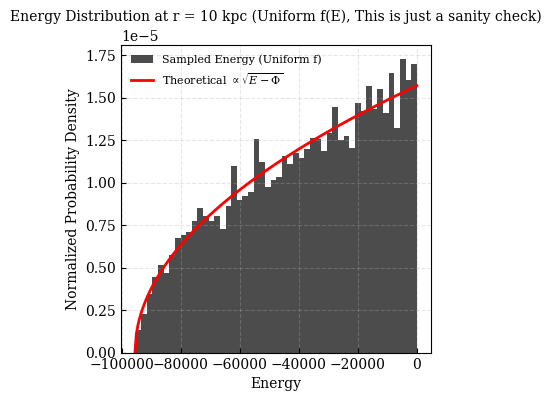

In [12]:
# Sanity Check: Energy Distribution (Uniform f(E))
r_fixed = 10  # fixed radius for testing, this can be changed to any radius from min to max and it follows the distribution pretty well
Phi_fixed = -G * M / (r_fixed + a)
N_E = 10000
E_samples_uniform = np.array([sample_energy_uniform(r_fixed) for _ in range(N_E)])
E_grid = np.linspace(Phi_fixed, 0.0, 200)
# For uniform f(E), p(E|r) ∝ sqrt(E - Φ), so:
p_E_theory = np.sqrt(E_grid - Phi_fixed)
p_E_theory /= np.trapz(p_E_theory, E_grid)  # Normalize

plt.figure(figsize=(4,4))
plt.hist(E_samples_uniform, bins=50, density=True, alpha=0.7, label="Sampled Energy (Uniform f)",color='k')
plt.plot(E_grid, p_E_theory, 'r-', lw=2, label=r"Theoretical $\propto \sqrt{E-\Phi}$")
plt.xlabel("Energy")
plt.ylabel("Normalized Probability Density")
plt.title(f"Energy Distribution at r = {r_fixed} kpc (Uniform f(E), This is just a sanity check)",fontsize=10)
plt.legend(frameon=False,fontsize=8)
plt.grid(True, ls="--", alpha=0.3)
plt.show()

In [13]:
# Main Simulation: Generate Velocities for All Particles that their energies where accepted
velocities = np.empty((N, 3))
energies = np.empty(N)
for i in tqdm(range(N), desc="Sampling Velocities"):
    velocities[i], energies[i] = sample_velocity_at_r(radii[i])

# Compute the radial component of the velocity
vr = np.empty(N)
for i in range(N):
    vr[i] = np.dot(positions[i], velocities[i]) / radii[i]

Sampling Velocities: 100%|██████████| 1000000/1000000 [30:37<00:00, 544.09it/s]


In [67]:
# Bin Data to Compute Radial Velocity Dispersion
nbins = 45 #this again can be changed
r_min = np.min(radii)
r_max = np.max(radii)
bins = np.logspace(np.log10(r_min), np.log10(r_max), nbins)
inds = np.digitize(radii, bins) #assigning each radius to a particular bin
sigma_r2 = np.empty(nbins)
r_bin_centers = np.empty(nbins)

for j in range(1, nbins):
    in_bin = (inds == j)
    if np.sum(in_bin) > 0:
        sigma_r2[j-1] = np.mean(vr[in_bin]**2)
        r_bin_centers[j-1] = np.mean(radii[in_bin])
    else:
        sigma_r2[j-1] = np.nan
        r_bin_centers[j-1] = np.nan

/tmp/ipykernel_15999/1126800467.py:92: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.where(value > 0, np.sqrt(value), np.nan)


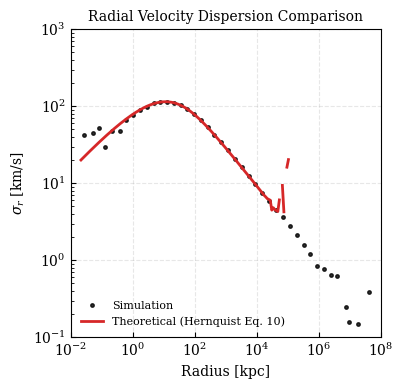

In [68]:
# Create a range of radii for plotting the theoretical σ_r
r_vals = np.logspace(np.log10(r_min), np.log10(r_max), 200)
sigma_r_theory_vals = sigma_r_theoretical(r_vals)
sigma_r_sim = np.sqrt(sigma_r2)

plt.figure(figsize=(4,4))
plt.loglog(r_bin_centers, sigma_r_sim, '.', label="Simulation", color='k',alpha=0.8,markersize=5)
plt.loglog(r_vals, sigma_r_theory_vals, '-', label="Theoretical (Hernquist Eq. 10)", color='tab:red')
plt.xlabel("Radius [kpc]")
plt.ylabel(r"$\sigma_r$ [km/s]")
plt.title("Radial Velocity Dispersion Comparison",fontsize=10)
plt.xlim(0.01,1e8)
plt.ylim(0.1,1e3)
plt.legend(frameon=False,fontsize=8,loc='lower left')
plt.grid(True, ls="--", alpha=0.3)
plt.show()


## How efficient is my code? Not very efficient....

The slowest part is calculating the grid of energies at each radius for sure. If I change ngrid from 200 to 20 The code runs in about 3 minutes for a million particles. But again it might not really capture the true $g_{\text{max}}$. It specially doesn't do a good job at small radii.

I'd really like to see the way you would do it and compare the efficiency. My code seemed at the same rate of it/s the whole time of running so I guess with using this method it is equally efficient at all radii.